In [1]:
#See Shear Catalog Document for details

#Import relevant libraries for working with CSV files
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

#Visualization libraries
import matplotlib.pyplot as plt

#Coordinate and search libraries via SciPy and AstroPy
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from scipy.spatial import cKDTree

In [4]:
#Read the shear catalog with no cuts 
shapeData = pd.read_csv('/data/HSC/shear_catalog/hsc_shear_no_cuts.csv')

In [6]:
# filter based on data quality criteria, borrowed from photoz/make_data.py
filt = (shapeData['gcmodel_mag'] > 0)\
        &(shapeData['rcmodel_mag'] > 0)\
        &(shapeData['icmodel_mag'] > 0)\
        &(shapeData['zcmodel_mag'] > 0)\
        &(shapeData['ycmodel_mag'] > 0)\
        &(shapeData['gcmodel_mag'] < 50)\
        &(shapeData['rcmodel_mag'] < 50)\
        &(shapeData['icmodel_mag'] < 50)\
        &(shapeData['zcmodel_mag'] < 50)\
        &(shapeData['ycmodel_mag'] < 50)

shapeData = shapeData[filt]

In [7]:
len(shapeData)

12023016

In [8]:
"""
Create a function that checks the number of neighbors within a separation limit
find_positional_duplicates(data, limit=0.8) takes two arguments:
- data is a DataFrame and assumes the following columns are in the DataFrame:
    + ira: the right ascension of the galaxy (J2000)
    + idec: the declination of the galaxy (J2000)
    + ishape_hsm_regaus_e2: the ellipitcity of a galaxy as determined by Reguassianization method (Hirata & Seljak; 2003)
- limit is the separation limit in arcsecs with a default of 0.8 arcsecs

Returns: a tuple containing the index values for the parent galaxy (first entry) and the child gaalxy (second entry)
"""
def find_positional_duplicates(data,limit=0.8):
    coords = SkyCoord(ra=data['ira'].values * u.degree, dec=data['idec'].values * u.degree, frame='icrs')
    
    # Calculate the distances and indices of nearby points using ckdtree.query
    kdtree = cKDTree(coords.cartesian.xyz.T)
    # The second argument of `query` is the maximum distance (0.8 arcsec converted to degrees)
    # The first return value is an array of distances, and the second return value is an array of indices
    r= (2 * np.sin(Angle(limit * u.arcsec.to(u.deg), unit=u.deg) / 2.0)).value
    
    dist, idxs = kdtree.query(coords.cartesian.xyz.T, k=1000, distance_upper_bound=r)
    
    #Find duplicates
    duplicates = []
    for i in range(len(idxs)):
        # Check if the second closest point exists within the distance threshold
        nearby_points = idxs[i][dist[i] < float('inf')]
        for j in nearby_points:
            if i < j:  # Avoid adding the point as a neighbor to itself
                duplicates.append((i, j))
    return duplicates

In [9]:
"""
Create a function that determines if two galaxies (parent and child galaxy) are duplicates based on an ellipticity component
same_shear(parent, cild, error=0.05) takes three arguments (two DataFrames and one float)
- parent is the parent galaxy (or presumed original galaxy)
    + We assume the galaxy has a column labeled ishape_hsm_regauss_e1
-child is a child galaxy DataFrame 
    + Same assumption as parent
-error is the amount of flexing room we are allowing to compare ellipticity values
    + by default this is set to a 5% error
    
returns a 1 if the child galaxy is indeed a dupliacte and a 0 otherwise
"""
def same_shear(parent, child, error=0.05):
    max_e1 = parent['ishape_hsm_regauss_e1'] * (1+error)
    min_e1 = parent['ishape_hsm_regauss_e1'] * (1-error)
    if min_e1 <= child['ishape_hsm_regauss_e2'] <= max_e1:
        return 1
    else:
        return 0

In [14]:
# Sample N galaxies from the shear catalog in order to determine the cut off limit for duplicates
sample = fullShearCat.sample(n=500000, random_state=89)

# Predetermined limits that we want to test
cutLimits = [5.0, 3.0, 2.0, 1.8, 1.4, 1, 0.8, 0.4, 0.1]

# Keep track of the ratio of galaxies removed with same shear vs total galaxies removed
ratio = []

"""
Loop through the differnt limits to test
- Makes use of the functions find_positional_duplicates and same_shear
- keeps track of objects removed and how many have the same shear
- stores information in a list of ratios
"""
for lim in cutLimits:
    
    #Index of galaxies in tuples 
    duplicateList = find_positional_duplicates(sample, lim)

    numRemoved = len(duplicateList) #total removed galaxies
    num_samee = 0

    #Check every pair of parent and child galaxy
    for pairs in duplicateList:
        num_samee += same_shear(sample.iloc[pairs[0]], sample.iloc[pairs[1]])
        
    #If the total number of removed galaxies is not 0, add it to ratios
    #...otherwise, add a negative value to visualize no galaxies removed
    if numRemoved != 0:
        ratio.append(num_samee/numRemoved)
    else:
        ratio.append(-0.001)


145.386396446


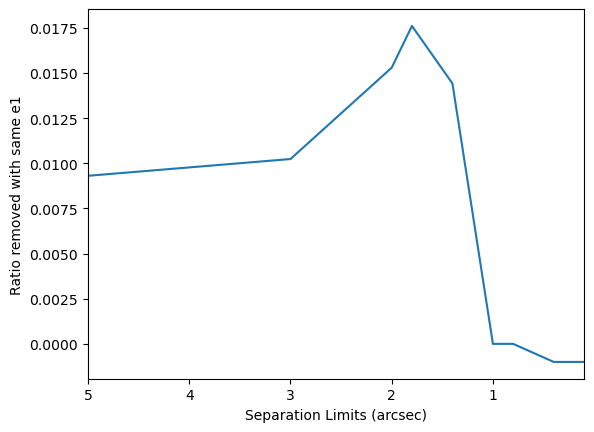

In [15]:
#Plot the ratios found above, 
#Goal is for the ratio to reach 100% as the separation decreases, we would determine cut limit this way
plt.plot(cutLimits, ratio)
plt.xlim(max(cutLimits), min(cutLimits)) #plot x-axis in reverse order
plt.xlabel('Separation Limits (arcsec)')
plt.ylabel('Ratio removed with same e1')
plt.show()

In [16]:
# Sample N galaxies from the shear catalog in order to determine the cut off limit for duplicates
sample = fullShearCat.sample(n=500000, random_state=42)


# Predetermined limits that we want to test
cutLimits = [5.0, 3.0, 2.0, 1.8, 1.4, 1, 0.8, 0.4, 0.1]

# Keep track of the ratio of galaxies removed with same shear vs total galaxies removed
ratio = []

"""
Loop through the differnt limits to test
- Makes use of the functions find_positional_duplicates and same_shear
- keeps track of objects removed and how many have the same shear
- stores information in a list of ratios
"""
for lim in cutLimits:
    
    #Index of galaxies in tuples 
    duplicateList = find_positional_duplicates(sample, lim)

    numRemoved = len(duplicateList) #total removed galaxies
    num_samee = 0

    #Check every pair of parent and child galaxy
    for pairs in duplicateList:
        num_samee += same_shear(sample.iloc[pairs[0]], sample.iloc[pairs[1]])
        
    #If the total number of removed galaxies is not 0, add it to ratios
    #...otherwise, add a negative value to visualize no galaxies removed
    if numRemoved != 0:
        ratio.append(num_samee/numRemoved)
    else:
        ratio.append(-0.001)

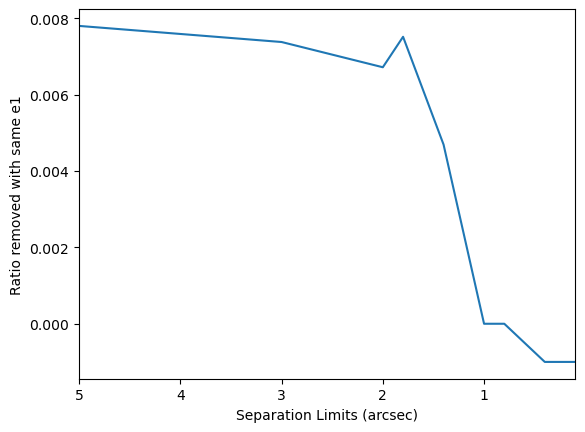

In [17]:
#Plot the ratios found above, 
#Goal is for the ratio to reach 100% as the separation decreases, we would determine cut limit this way
plt.plot(cutLimits, ratio)
plt.xlim(max(cutLimits), min(cutLimits)) #plot x-axis in reverse order
plt.xlabel('Separation Limits (arcsec)')
plt.ylabel('Ratio removed with same e1')
plt.show()

In [19]:
shapeData.to_csv('/data/HSC/shear_catalog/hsc_shear_with_cuts.csv', index=False)